In [1]:
import numpy as np
from matplotlib import pyplot as plt

import cv2
import torch
from torch import nn
from torchvision import transforms

In [2]:
transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize((224, 224)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                                ])
elephant_img = cv2.imread('images/elephant.jpg')
elephant_img = cv2.cvtColor(elephant_img, cv2.COLOR_BGR2RGB)
elephant = transform(elephant_img)

shark1_img = cv2.imread('images/shark1.jpg')
shark1_img = cv2.cvtColor(shark1_img, cv2.COLOR_BGR2RGB)
shark1 = transform(shark1_img)

shark2_img = cv2.imread('images/shark2.jpg')
shark2_img = cv2.cvtColor(shark2_img, cv2.COLOR_BGR2RGB)
shark2= transform(shark2_img)

deer_img = cv2.imread('images/deer.jpg')
deer_img = cv2.cvtColor(deer_img, cv2.COLOR_BGR2RGB)
deer = transform(deer_img)

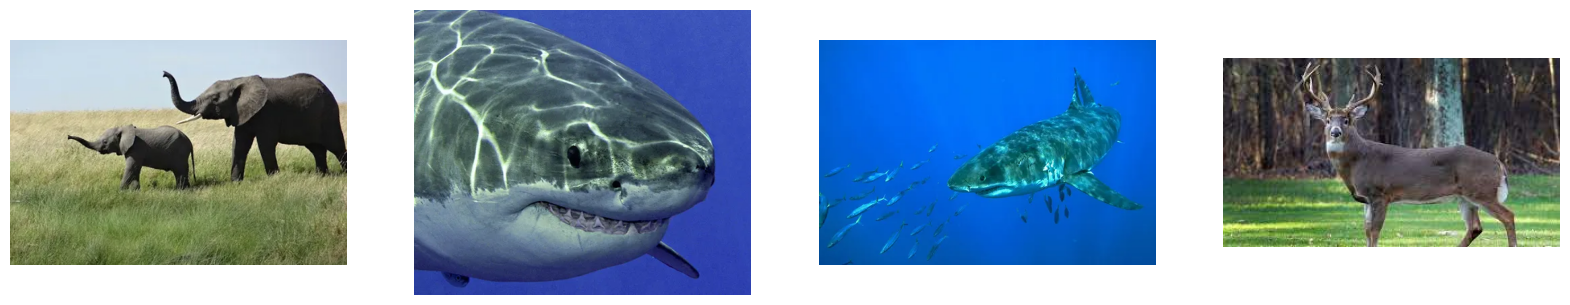

In [4]:
fig, axes = plt.subplots(1,4,figsize=(20,5))
axes[0].imshow(elephant_img)
axes[1].imshow(shark1_img)
axes[2].imshow(shark2_img)
axes[3].imshow(deer_img)
for ax in axes:
    ax.axis('off')

In [5]:
from torchvision.models import vgg19
model = vgg19(pretrained=True)

/home/choiyj/.conda/envs/choi/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/choiyj/.conda/envs/choi/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [43]:
from torchvision.models import VGG19_Weights
label_names = VGG19_Weights.DEFAULT.value.meta['categories']

In [44]:
model.eval()
print(label_names[model(elephant.unsqueeze(0)).argmax()])
print(label_names[model(shark1.unsqueeze(0)).argmax()])
print(label_names[model(shark2.unsqueeze(0)).argmax()])
print(label_names[model(deer.unsqueeze(0)).argmax()])

African elephant
great white shark
great white shark
gazelle


compute gradient by applying .backward() method to the most probable logit : activation map of last convolutional layer<br>
--> gradients are discarded as soon as the gradient propagates through them on way back.

hook (callback function of PyTorch) : How to attatch a hool to our intermediate values to pull gradients out of the model before they discared.

We have to register the backward hook to the activation map of the last convolutional layer in our model.


In [ ]:
# 출력 생략
model

# Weight를 추적하기 위해 모델 재정의

In [41]:
import copy
VGG19 = vgg19(pretrained=True)
class VGG(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = copy.deepcopy(VGG19)

        # To get the gradient of last convolutional layer
        self.conv = self.model.features[:36]

        # after get conv
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

        # get the fully connected layers
        self.classifier = self.model.classifier

        # placeholder for gradients
        self.gradient = None

    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradient = grad

    def forward(self,x):
        x = self.conv(x)

        # register the hook
        # https://pytorch.org/docs/stable/generated/torch.Tensor.register_hook.html
        # Tensor.register_hook(hook) -> Tensor or None
        h = x.register_hook(self.activations_hook)

        # apply remaining layers
        x = self.max_pool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        return x

/home/choiyj/.conda/envs/choi/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/choiyj/.conda/envs/choi/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [45]:
model = VGG()
model.eval()
pred_elephant = model(elephant.unsqueeze(0))
pred_shark1 = model(shark1.unsqueeze(0))
pred_shark2 = model(shark1.unsqueeze(0))
pred_deer = model(deer.unsqueeze(0))

print(label_names[pred_elephant.argmax()])
print(label_names[pred_shark1.argmax()])
print(label_names[pred_shark2.argmax()])
print(label_names[pred_deer.argmax()])

African elephant
great white shark
great white shark
gazelle


In [39]:
# None
model.gradient

In [40]:
# get the gradients of the output with respect to the parameters of the model
print(pred_elephant.size())
pred_elephant[:,pred_elephant.argmax()].backward()

torch.Size([1, 1000])


In [41]:
# pull the gradients out of the model
gradients = model.gradient
print('gradient size : ',gradients.size())

print('(참고) output size of convolution layer : ',copy.deepcopy(model).conv(elephant.unsqueeze(0)).shape)

gradient size :  torch.Size([1, 512, 14, 14])
(참고) output size of convolution layer :  torch.Size([1, 512, 14, 14])


In [42]:
# pool the gradients across the channels
# 논문의 수식 참고 (a_k^c)
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
print(pooled_gradients.size())

torch.Size([512])


In [44]:
# get the activations of the last convolutional layer
activations = model.conv(elephant.unsqueeze(0)).detach()
print(activations.size())

torch.Size([1, 512, 14, 14])


In [45]:
# weight the channels by corresponding gradients
# 논문의 수식 참고 (L^c_{grad-cam} = relu(linear combination of a_k^c * w_k^c))
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()
# relu
heatmap = np.maximum(heatmap, 0)
print(heatmap.size())

torch.Size([14, 14])


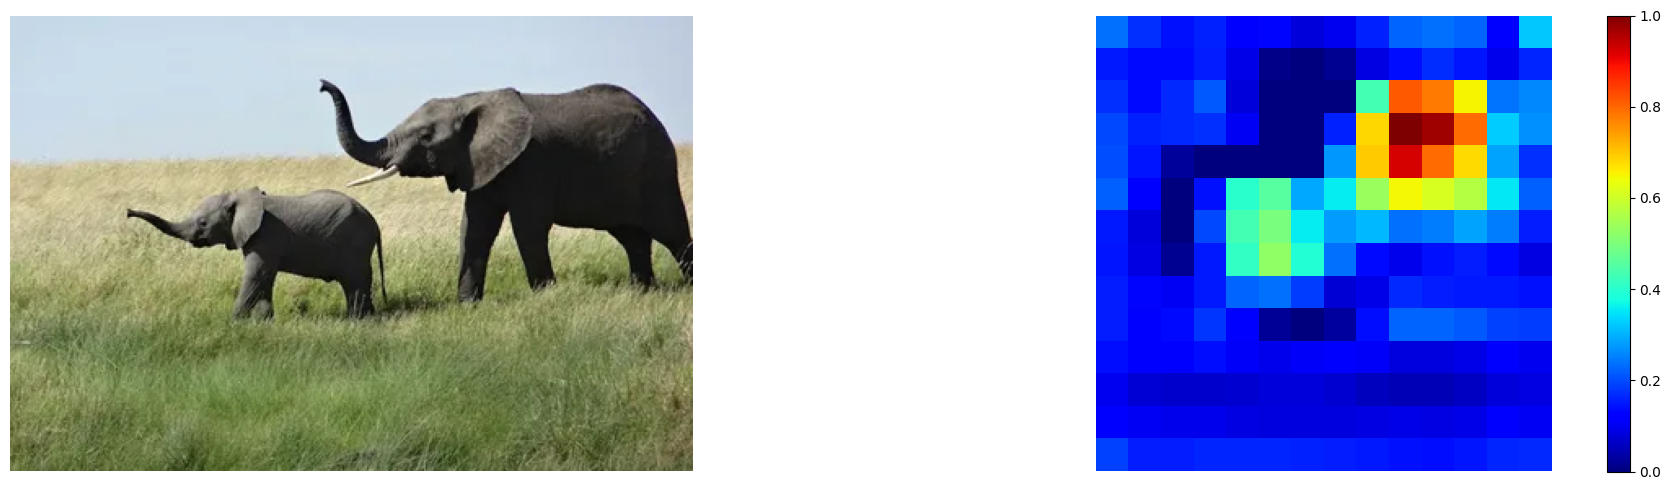

In [46]:
# normalize the heatmap
heatmap /= torch.max(heatmap)

fig, axes = plt.subplots(1,2,figsize=(20,5))
axes[0].imshow(elephant_img)
im = axes[1].matshow(heatmap.squeeze(), cmap='jet')
fig.colorbar(im)
for ax in axes:
    ax.axis('off')
plt.tight_layout()


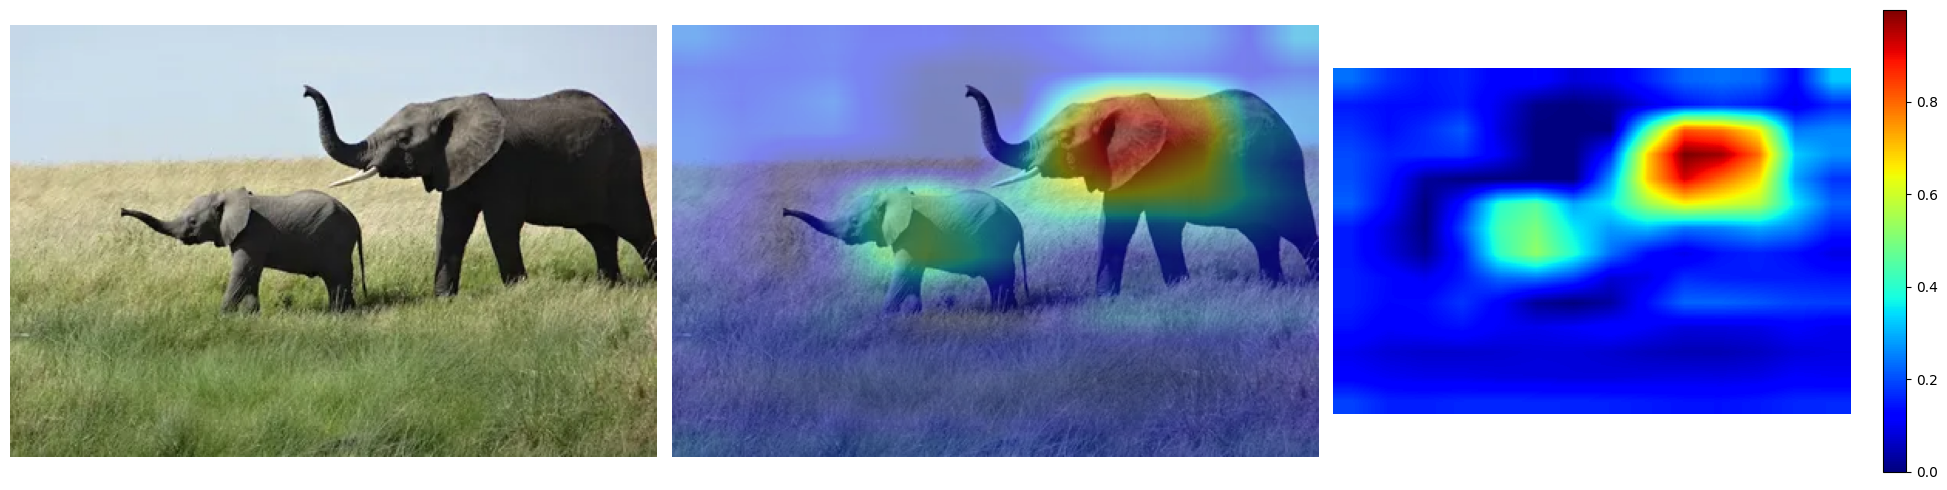

In [48]:
# (projection) 14*14 -> original image space : the resolution of the heatmap may be exaggerated
# especially the smaller the size of the activation map of the last convolution layer (EX) DenseNet : 7*7)
heatmap_resize = cv2.resize(heatmap.numpy(), (elephant_img.shape[1], elephant_img.shape[0]))
# heatmap_resize = cv2.applyColorMap(np.uint8(heatmap_resize*255), cv2.COLORMAP_JET)
# elephant_heatmap = elephant_img + heatmap_resize*0.4

fig, axes = plt.subplots(1,3,figsize=(20,5))
axes[0].imshow(elephant_img)
axes[1].imshow(elephant_img)
axes[1].matshow(heatmap_resize, alpha=0.4, cmap='jet')
im = axes[2].matshow(heatmap_resize,cmap='jet')
fig.colorbar(im)
for ax in axes:
    ax.axis('off')
plt.tight_layout()

In [3]:
from torchvision.models import resnet18

resnet = resnet18(pretrained=True)

/home/choiyj/.conda/envs/choi/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/choiyj/.conda/envs/choi/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
from source import gradcam
conv = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool,
                     resnet.layer1, resnet.layer2, resnet.layer3, resnet.layer4)
classifier = nn.Sequential(resnet.avgpool, nn.Flatten(), resnet.fc)
resnet_gradcam = gradcam.GradCamModel(conv, classifier)
resnet_gradcam.eval()
print('resnet')

resnet


In [7]:
# resnet_gradcam = GradCamModel(resnet)
_ = resnet_gradcam(elephant.unsqueeze(0))
heatmap_elephant = resnet_gradcam.get_heatmap(elephant.unsqueeze(0))

_ = resnet_gradcam(shark1.unsqueeze(0))
heatmap_shark1 = resnet_gradcam.get_heatmap(shark1.unsqueeze(0))

_ = resnet_gradcam(shark2.unsqueeze(0))
heatmap_shark2 = resnet_gradcam.get_heatmap(shark2.unsqueeze(0))

_ = resnet_gradcam(deer.unsqueeze(0))
heatmap_deer = resnet_gradcam.get_heatmap(deer.unsqueeze(0))

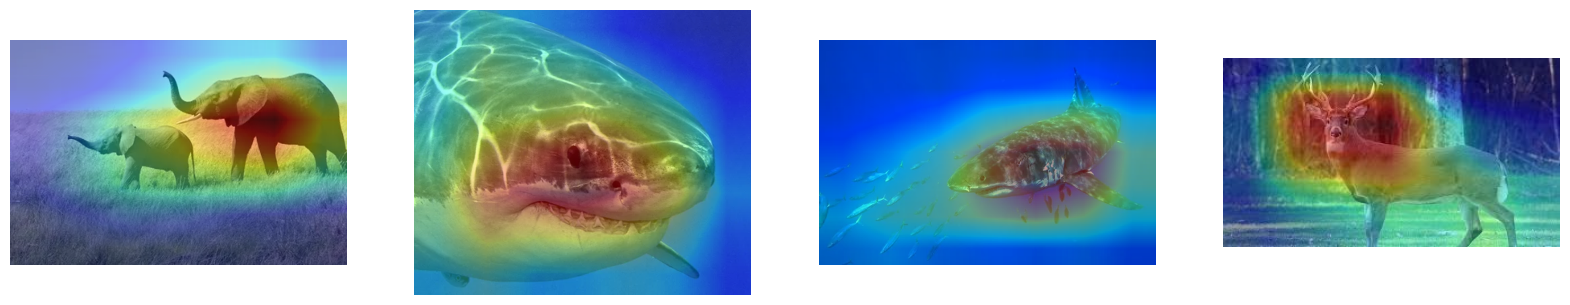

In [8]:
fig, axes = plt.subplots(1,4,figsize=(20,5))
axes[0].imshow(elephant_img)
axes[0].matshow(cv2.resize(heatmap_elephant.numpy(), (elephant_img.shape[1], elephant_img.shape[0])),
                alpha=0.4, cmap='jet')
axes[1].imshow(shark1_img)
axes[1].matshow(cv2.resize(heatmap_shark1.numpy(), (shark1_img.shape[1], shark1_img.shape[0])),
                alpha=0.4, cmap='jet')
axes[2].imshow(shark2_img)
axes[2].matshow(cv2.resize(heatmap_shark2.numpy(), (shark2_img.shape[1], shark2_img.shape[0])),
                alpha=0.4, cmap='jet')
axes[3].imshow(deer_img)
axes[3].matshow(cv2.resize(heatmap_deer.numpy(), (deer_img.shape[1], deer_img.shape[0])),
                alpha=0.4, cmap='jet')
for ax in axes:
    ax.axis('off')

In [ ]:
from torchvision.models import densenet121
model = densenet121(pretrained=True)

In [32]:
from torch.nn import functional as F

class pre_classifier(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        x = F.relu(x, inplace=True)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        return x

conv = model.features
classifier = nn.Sequential(pre_classifier(), model.classifier)

densenet121_gradcam = gradcam.GradCamModel(conv, classifier)
densenet121_gradcam.eval()
print('densenet121')

densenet121


In [33]:
_ = densenet121_gradcam(elephant.unsqueeze(0))
heatmap_elephant = densenet121_gradcam.get_heatmap(elephant.unsqueeze(0))

_ = densenet121_gradcam(shark1.unsqueeze(0))
heatmap_shark1 = densenet121_gradcam.get_heatmap(shark1.unsqueeze(0))

_ = densenet121_gradcam(shark2.unsqueeze(0))
heatmap_shark2 = densenet121_gradcam.get_heatmap(shark2.unsqueeze(0))

_ = densenet121_gradcam(deer.unsqueeze(0))
heatmap_deer = densenet121_gradcam.get_heatmap(deer.unsqueeze(0))

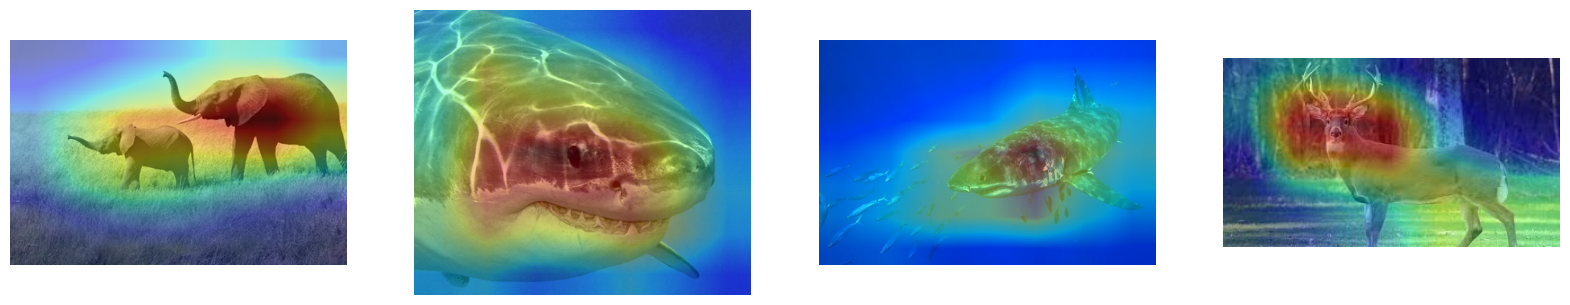

In [34]:
fig, axes = plt.subplots(1,4,figsize=(20,5))
axes[0].imshow(elephant_img)
axes[0].matshow(cv2.resize(heatmap_elephant.numpy(), (elephant_img.shape[1], elephant_img.shape[0])),
                alpha=0.4, cmap='jet')
axes[1].imshow(shark1_img)
axes[1].matshow(cv2.resize(heatmap_shark1.numpy(), (shark1_img.shape[1], shark1_img.shape[0])),
                alpha=0.4, cmap='jet')
axes[2].imshow(shark2_img)
axes[2].matshow(cv2.resize(heatmap_shark2.numpy(), (shark2_img.shape[1], shark2_img.shape[0])),
                alpha=0.4, cmap='jet')
axes[3].imshow(deer_img)
axes[3].matshow(cv2.resize(heatmap_deer.numpy(), (deer_img.shape[1], deer_img.shape[0])),
                alpha=0.4, cmap='jet')
for ax in axes:
    ax.axis('off')